In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import warnings
import json

In [2]:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [3]:
final_district_xgb_model = xgb.Booster()
final_district_xgb_model.load_model('models/final_district_xgb_model.json')

In [4]:
final_district_xgb_model

In [5]:
top_features = [
    'bus_stops_distance_0.1',
    'alleylights_distance_0.1',
    'police_stations_distance_1',
    'streetlights_oneout_distance_0.1',
    'streetlights_allout_distance_0.5',
    'streetlights_oneout_distance_0.3',
    'streetlights_allout_distance_0.3',
    'bike_rides_within_0.5_and_15_min',
    'area_crimes_3_hours_prev',
    'area_crimes_1_hours_prev',
    'alleylights_distance_0.3',
    'bike_rides_within_0.1_and_10_min',
    'bike_rides_within_0.1_and_5_min',
]

In [302]:
area_df = pd.read_csv('../../data/pre_training/area_pre_feature_selection_nonnormalized.csv')
dis_area_df = pd.read_csv('../../data/pre_training/dis_area_pre_feature_selection_nonnormalized.csv')
district_df = pd.read_csv('../../data/pre_training/district_pre_feature_selection_nonnormalized.csv')

In [303]:
area_df_selected = area_df[top_features]
dis_area_df_selected = dis_area_df[top_features]
district_df_selected = district_df[top_features]

In [434]:
factor_mapping = {
    'Bike Activity': [
        'bike_rides_within_0.5_and_15_min', 
        'bike_rides_within_0.1_and_10_min', 
        'bike_rides_within_0.1_and_5_min'
    ],
    'Alleylight Outages': [
        'alleylights_distance_0.1',
        'alleylights_distance_0.3'
    ],
    'Streetlight Outages': [
        'streetlights_allout_distance_0.5',
        'streetlights_allout_distance_0.3'
    ],
    'Partial Streetlight Outages': [
        'streetlights_oneout_distance_0.1',
        'streetlights_oneout_distance_0.3'
    ],
    'Recent Crime Activity': [
        'area_crimes_3_hours_prev',
        'area_crimes_1_hours_prev'
    ]
}

In [9]:
def simulation(df, ref_df, thresholds):
    simmed_dfs = {}
    
    for factor in factor_mapping.keys():
        target_cols = factor_mapping[factor]

        for threshold in thresholds:
            threshold = round(threshold, 2)
            temp_df = df.copy()

            if threshold < 0:
                random_factors = np.random.uniform(1 - abs(threshold), 1, size=temp_df[target_cols].shape)
                temp_df.loc[:, target_cols] = temp_df[target_cols] * random_factors
            else:
                random_factors = np.random.uniform(1, 1 + threshold, size=temp_df[target_cols].shape)
                random_additions = np.random.choice([0, 1], size=temp_df[target_cols].shape, p=[1 - threshold, threshold])
                temp_df.loc[:, target_cols] = (temp_df[target_cols] + random_additions) * random_factors

            temp_df = pd.concat([temp_df, ref_df], axis=1)
            simmed_dfs[f'{factor.replace(" ", "_").lower()}_{threshold}'] = temp_df

    return simmed_dfs

In [304]:
district_sims = simulation(district_df[top_features], district_df[['district', 'date_hour']], [-0.1, -0.05, 0.05, 0.1])
area_sims = simulation(area_df[top_features], area_df[['area_id', 'date_hour']], [-0.1, -0.05, 0.05, 0.1])
dis_area_sims = simulation(dis_area_df[top_features], dis_area_df[['dis_area_id', 'date_hour']], [-0.1, -0.05, 0.05, 0.1])

##### Rerun model with the new dataset

In [305]:
def predict_simulations(model, drops, sim_dfs, filepath=None):
    predictions = {}
    for threshold, sim_df in sim_dfs.items():
        dmatrix = xgb.DMatrix(sim_df.drop(drops, axis=1))
        prediction = model.predict(dmatrix)
        predictions[threshold] = prediction

        print(f'Predictions for {threshold} completed')

    predictions_serializable = {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in predictions.items()}
    if filepath:
        with open(filepath, 'w') as f:
            json.dump(predictions_serializable, f)

    return predictions

In [15]:
district_predictions = predict_simulations(final_district_xgb_model, ['district', 'date_hour'], district_sims, '../../data/simulations/district_predictions.json')

Predictions for bike_activity_-0.1 completed
Predictions for bike_activity_-0.05 completed
Predictions for bike_activity_0.05 completed
Predictions for bike_activity_0.1 completed
Predictions for alleylight_availability_-0.1 completed
Predictions for alleylight_availability_-0.05 completed
Predictions for alleylight_availability_0.05 completed
Predictions for alleylight_availability_0.1 completed
Predictions for streetlight_outages_-0.1 completed
Predictions for streetlight_outages_-0.05 completed
Predictions for streetlight_outages_0.05 completed
Predictions for streetlight_outages_0.1 completed
Predictions for partial_streetlight_outages_-0.1 completed
Predictions for partial_streetlight_outages_-0.05 completed
Predictions for partial_streetlight_outages_0.05 completed
Predictions for partial_streetlight_outages_0.1 completed
Predictions for recent_crime_activity_-0.1 completed
Predictions for recent_crime_activity_-0.05 completed
Predictions for recent_crime_activity_0.05 completed


In [16]:
area_predictions = predict_simulations(final_district_xgb_model, ['area_id', 'date_hour'], area_sims, '../../data/simulations/area_predictions.json')

Predictions for bike_activity_-0.1 completed
Predictions for bike_activity_-0.05 completed
Predictions for bike_activity_0.05 completed
Predictions for bike_activity_0.1 completed
Predictions for alleylight_availability_-0.1 completed
Predictions for alleylight_availability_-0.05 completed
Predictions for alleylight_availability_0.05 completed
Predictions for alleylight_availability_0.1 completed
Predictions for streetlight_outages_-0.1 completed
Predictions for streetlight_outages_-0.05 completed
Predictions for streetlight_outages_0.05 completed
Predictions for streetlight_outages_0.1 completed
Predictions for partial_streetlight_outages_-0.1 completed
Predictions for partial_streetlight_outages_-0.05 completed
Predictions for partial_streetlight_outages_0.05 completed
Predictions for partial_streetlight_outages_0.1 completed
Predictions for recent_crime_activity_-0.1 completed
Predictions for recent_crime_activity_-0.05 completed
Predictions for recent_crime_activity_0.05 completed


In [306]:
dis_area_predictions = predict_simulations(final_district_xgb_model, ['dis_area_id', 'date_hour'], dis_area_sims, '../../data/simulations/dis_area_predictions.json')

Predictions for bike_activity_-0.1 completed
Predictions for bike_activity_-0.05 completed
Predictions for bike_activity_0.05 completed
Predictions for bike_activity_0.1 completed
Predictions for alleylight_availability_-0.1 completed
Predictions for alleylight_availability_-0.05 completed
Predictions for alleylight_availability_0.05 completed
Predictions for alleylight_availability_0.1 completed
Predictions for streetlight_outages_-0.1 completed
Predictions for streetlight_outages_-0.05 completed
Predictions for streetlight_outages_0.05 completed
Predictions for streetlight_outages_0.1 completed
Predictions for partial_streetlight_outages_-0.1 completed
Predictions for partial_streetlight_outages_-0.05 completed
Predictions for partial_streetlight_outages_0.05 completed
Predictions for partial_streetlight_outages_0.1 completed
Predictions for recent_crime_activity_-0.1 completed
Predictions for recent_crime_activity_-0.05 completed
Predictions for recent_crime_activity_0.05 completed


In [12]:
district_dmatrix = xgb.DMatrix(district_df_selected)
control_district_predictions = final_district_xgb_model.predict(district_dmatrix)

In [13]:
area_dmatrix = xgb.DMatrix(area_df_selected)
control_area_predictions = final_district_xgb_model.predict(area_dmatrix)

In [308]:
dis_area_dmatrix = xgb.DMatrix(dis_area_df_selected)
control_dis_area_predictions = final_district_xgb_model.predict(dis_area_dmatrix)

##### Calculate Residuals Across Geospatial Factors

In [15]:
def calculate_residuals(predictions, test_labels, geodata, filepath=None):
    residuals = {}
    for threshold, prediction in predictions.items():
        temp_df = pd.DataFrame(data={'geo':geodata, 'actual_crime':test_labels, 'new_crime':prediction})
        avg_grouped_residuals = temp_df.groupby('geo')[['actual_crime', 'new_crime']].agg('mean').reset_index()
        avg_grouped_residuals.rename(columns={'actual_crime':'avg_actual_crime', 'new_crime':'avg_new_crime'}, inplace=True)
        avg_grouped_residuals['avg_diff'] = avg_grouped_residuals['avg_actual_crime'] - avg_grouped_residuals['avg_new_crime']
        avg_grouped_residuals['avg_perc_diff'] = (avg_grouped_residuals['avg_new_crime'] - avg_grouped_residuals['avg_actual_crime']) / avg_grouped_residuals['avg_actual_crime'] * 100

        tot_grouped_residuals = temp_df.groupby('geo')[['actual_crime', 'new_crime']].agg('sum').reset_index()
        tot_grouped_residuals.rename(columns={'actual_crime':'tot_actual_crime', 'new_crime':'tot_new_crime'}, inplace=True)
        tot_grouped_residuals['tot_diff'] = tot_grouped_residuals['tot_actual_crime'] - tot_grouped_residuals['tot_new_crime']
        tot_grouped_residuals['tot_perc_diff'] = (tot_grouped_residuals['tot_new_crime'] - tot_grouped_residuals['tot_actual_crime']) / tot_grouped_residuals['tot_actual_crime'] * 100

        residuals[threshold] = pd.merge(avg_grouped_residuals, tot_grouped_residuals, on='geo', how='inner')
    
        residuals_serializable = {
            k: v.values.tolist() if isinstance(v, pd.DataFrame) else (v.tolist() if isinstance(v, pd.Series) else v)
            for k, v in residuals.items()
        }
        if filepath:
            with open(filepath, 'w') as f:
                json.dump(residuals_serializable, f)

    return residuals

In [20]:
district_residuals = calculate_residuals(district_predictions, control_district_predictions, district_df['district'], '../../data/simulations/district_residuals.json')

In [21]:
area_residuals = calculate_residuals(area_predictions, control_area_predictions, area_df['area_id'], '../../data/simulations/area_residuals.json')

In [309]:
dis_area_residuals = calculate_residuals(dis_area_predictions, control_dis_area_predictions, dis_area_df['dis_area_id'], '../../data/simulations/dis_area_residuals.json')

##### Read In Saved Data

In [19]:
with open('../../data/simulations/area_predictions.json', 'r') as file:
    area_predictions = json.load(file)

with open('../../data/simulations/area_residuals.json', 'r') as file:
    area_residuals = json.load(file)

with open('../../data/simulations/dis_area_predictions.json', 'r') as file:
    dis_area_predictions = json.load(file)

with open('../../data/simulations/dis_area_residuals.json', 'r') as file:
    dis_area_residuals = json.load(file)

with open('../../data/simulations/district_predictions.json', 'r') as file:
    district_predictions = json.load(file)

with open('../../data/simulations/district_residuals.json', 'r') as file:
    district_residuals = json.load(file)

In [ ]:
def convert_dict_to_dataframe(data_dict):
    for key, val in data_dict.items():
        columns = [
            'geo', 'avg_actual_crime', 'avg_new_crime', 'avg_diff', 
            'avg_perc_diff', 'tot_actual_crime', 'tot_new_crime', 
            'tot_diff', 'tot_perc_diff'
        ]
        df = pd.DataFrame(val)
        df.columns = columns
        data_dict[key] = df
    return data_dict

area_residuals_df = convert_dict_to_dataframe(area_residuals)
dis_area_residuals_df = convert_dict_to_dataframe(dis_area_residuals)
district_residuals_df = convert_dict_to_dataframe(district_residuals)

##### Finding the Largest Impact

In [185]:
def largest_impact(dic, n=None, threshold=None, sign=None, void_factors=None, void_geos=None):
    all_results = []

    for threshold_key, df in dic.items():
        if threshold_key not in void_factors:
            df['abs_avg_perc_diff'] = df['avg_perc_diff'].abs()

            if threshold is not None:
                df = df[df['abs_avg_perc_diff'] > threshold]

            if sign == 'positive':
                df = df[df['avg_perc_diff'] > 0]
            elif sign == 'negative':
                df = df[df['avg_perc_diff'] < 0]

            if void_geos is not None:
                df = df[~df['geo'].isin(void_geos)]

            if n is not None:
                df = df.nlargest(n, 'abs_avg_perc_diff', keep='all')

            df['threshold'] = threshold_key
            all_results.append(df)

    combined_df = pd.concat(all_results)
    sorted_df = combined_df.sort_values(by='abs_avg_perc_diff', ascending=False).drop(columns='abs_avg_perc_diff')
    
    return sorted_df

In [153]:
largest_impact(area_residuals_df, threshold=1, void=['recent_crime_activity_-0.1', 'recent_crime_activity_-0.05', 'recent_crime_activity_0.05', 'recent_crime_activity_0.1'])

,geo,avg_actual_crime,avg_new_crime,avg_diff,avg_perc_diff,tot_actual_crime,tot_new_crime,tot_diff,tot_perc_diff,threshold
8,9,0.000408,0.001363,-0.000956,234.355106,17.879543,59.781167,-41.901623,234.355110,partial_streetlight_outages_0.1
46,47,0.000734,0.001709,-0.000975,132.847872,32.191528,74.957287,-42.765758,132.847866,partial_streetlight_outages_0.1
73,74,0.000809,0.001814,-0.001005,124.287920,35.470726,79.556556,-44.085830,124.287925,partial_streetlight_outages_0.1
8,9,0.000408,0.000910,-0.000503,123.271566,17.879543,39.919937,-22.040394,123.271569,partial_streetlight_outages_0.05
11,12,0.000829,0.001843,-0.001015,122.466282,36.333870,80.830610,-44.496740,122.466284,partial_streetlight_outages_0.1
36,37,0.000818,0.001798,-0.000980,119.763925,71.733223,157.643751,-85.910528,119.763931,partial_streetlight_outages_0.1
8,9,0.000408,0.000826,-0.000419,102.660945,17.879543,36.234852,-18.355309,102.660947,bike_activity_0.1
46,47,0.000734,0.001247,-0.000513,69.896443,32.191528,54.692260,-22.500732,69.896438,partial_streetlight_outages_0.05
73,74,0.000809,0.001325,-0.000516,63.803430,35.470726,58.102267,-22.631541,63.803434,partial_streetlight_outages_0.05
54,55,0.000826,0.001345,-0.000519,62.770698,36.238533,58.985711,-22.747178,62.770693,partial_streetlight_outages_0.05


In [55]:
largest_impact(dis_area_residuals_df, threshold=1, void=['recent_crime_activity_-0.1', 'recent_crime_activity_-0.05', 'recent_crime_activity_0.05', 'recent_crime_activity_0.1'])

,geo,avg_actual_crime,avg_new_crime,avg_diff,avg_perc_diff,tot_actual_crime,tot_new_crime,tot_diff,tot_perc_diff,threshold
39,40,1.759234e-07,0.000916,-0.000916,520807.585114,0.046283,241.093371,-241.047088,520807.565135,partial_streetlight_outages_0.1
39,40,1.759234e-07,0.000471,-0.000471,267823.807245,0.046283,124.004057,-123.957774,267823.796969,partial_streetlight_outages_0.05
39,40,1.759234e-07,0.000398,-0.000398,226002.183691,0.046283,104.647618,-104.601334,226002.175019,bike_activity_0.1
39,40,1.759234e-07,0.000208,-0.000208,118240.444709,0.046283,54.771897,-54.725614,118240.440170,bike_activity_0.05
39,40,1.759234e-07,0.000049,-0.000049,28023.980766,0.046283,13.016715,-12.970431,28023.979687,streetlight_outages_0.1
39,40,1.759234e-07,0.000025,-0.000025,14135.775543,0.046283,6.588791,-6.542507,14135.774997,streetlight_outages_0.05
39,40,1.759234e-07,0.000017,-0.000017,9721.370993,0.046283,4.545657,-4.499374,9721.370617,alleylight_availability_0.1
39,40,1.759234e-07,0.000010,-0.000010,5402.298010,0.046283,2.546647,-2.500363,5402.297799,alleylight_availability_0.05
57,58,5.198941e-04,0.001454,-0.000934,179.659041,68.388954,191.255889,-122.866934,179.659034,partial_streetlight_outages_0.1
28,29,5.389585e-04,0.001484,-0.000945,175.383325,330.851501,911.109899,-580.258398,175.383335,partial_streetlight_outages_0.1


In [56]:
largest_impact(district_residuals_df, threshold=1, void=['recent_crime_activity_-0.1', 'recent_crime_activity_-0.05', 'recent_crime_activity_0.05', 'recent_crime_activity_0.1'])

,geo,avg_actual_crime,avg_new_crime,avg_diff,avg_perc_diff,tot_actual_crime,tot_new_crime,tot_diff,tot_perc_diff,threshold
22,31,1.759234e-07,0.000922,-0.000922,523871.020764,0.007714,40.418539,-40.410825,523871.011212,partial_streetlight_outages_0.1
22,31,1.759234e-07,0.000477,-0.000477,271182.757212,0.007714,20.926449,-20.918735,271182.752266,partial_streetlight_outages_0.05
22,31,1.759234e-07,0.000392,-0.000392,222828.145824,0.007714,17.196428,-17.188714,222828.141760,bike_activity_0.1
22,31,1.759234e-07,0.000212,-0.000212,120594.491980,0.007714,9.310238,-9.302524,120594.489780,bike_activity_0.05
22,31,1.759234e-07,0.000049,-0.000049,27682.690495,0.007714,2.143126,-2.135412,27682.689988,streetlight_outages_0.1
22,31,1.759234e-07,0.000025,-0.000025,14024.926406,0.007714,1.089581,-1.081867,14024.926149,streetlight_outages_0.05
22,31,1.759234e-07,0.000018,-0.000017,9906.123627,0.007714,0.771861,-0.764147,9906.123445,alleylight_availability_0.1
22,31,1.759234e-07,0.000010,-0.000009,5361.735019,0.007714,0.421312,-0.413598,5361.734919,alleylight_availability_0.05
18,20,5.487488e-03,0.006915,-0.001427,26.011358,240.615356,303.202680,-62.587323,26.011359,partial_streetlight_outages_0.1
14,16,9.851090e-03,0.011781,-0.001930,19.594405,431.950592,516.588725,-84.638133,19.594401,partial_streetlight_outages_0.1


##### Visualize the Differences

In [57]:
clean_police_districts = pd.read_csv('../../data/processed/clean_police_districts.csv')
clean_areas = pd.read_csv('../../data/processed/clean_areas.csv')
disadvantaged_areas_within_areas = pd.read_csv('../../data/processed/disadvantaged_areas_within_areas.csv')

In [58]:
def parse_polygon(polygon_string):
    points = polygon_string.strip('POLYGON ((').strip('))').split(', ')
    points = [tuple(map(float, point.split())) for point in points]
    return Polygon(points)

In [59]:
def swap_coordinates(polygon):
    if polygon.is_empty:
        return polygon
    swapped_coords = [(y, x) for x, y in polygon.exterior.coords]
    return Polygon(swapped_coords)

In [60]:
clean_police_districts['geom'] = clean_police_districts['geom'].apply(parse_polygon)
clean_police_districts['geom'] = clean_police_districts['geom'].apply(swap_coordinates)
clean_police_districts.head()

,district,geom,disadvantaged_score,disadvantaged_score.1,centroid,status,areas
0,17,POLYGON ((-87.71067089391354 41.99736565536943...,0.0,0.0,0.0,0.0,0.0
1,20,POLYGON ((-87.66029423572358 41.99091633853977...,4.0,4.0,4.0,4.0,4.0
2,31,POLYGON ((-87.82817787271652 41.98384222028714...,0.0,0.0,0.0,0.0,0.0
3,31,POLYGON ((-87.83365455160555 41.97535481526603...,0.0,0.0,0.0,0.0,0.0
4,19,POLYGON ((-87.64491798568677 41.96972709381482...,2.0,2.0,2.0,2.0,2.0


In [61]:
clean_areas['poly'] = clean_areas['poly'].apply(parse_polygon)
clean_areas['poly'] = clean_areas['poly'].apply(swap_coordinates)
clean_areas.head()

,id,poly,district
0,35,POLYGON ((-87.60914087617894 41.84469250265398...,2
1,36,POLYGON ((-87.59215283879394 41.81692934626684...,2
2,37,POLYGON ((-87.62879823733725 41.80189303368919...,9
3,38,"POLYGON ((-87.6067081256125 41.81681377057218,...",2
4,39,POLYGON ((-87.59215283879394 41.81692934626684...,2


In [62]:
disadvantaged_areas_within_areas['poly'] = disadvantaged_areas_within_areas['poly'].apply(parse_polygon)
disadvantaged_areas_within_areas['poly'] = disadvantaged_areas_within_areas['poly'].apply(swap_coordinates)
disadvantaged_areas_within_areas['id'] = disadvantaged_areas_within_areas.index
disadvantaged_areas_within_areas.head()

,poly,district,areas,id
0,POLYGON ((-87.57366299996758 41.70796600003142...,4,51,0
1,POLYGON ((-87.60151899995586 41.68632499999862...,5,50,1
2,POLYGON ((-87.60036199996543 41.69284299996604...,5,50,2
3,POLYGON ((-87.62032800000847 41.69942700001048...,5,49,3
4,POLYGON ((-87.66036699995497 41.75771799998948...,6,71,4


In [63]:
clean_areas.rename(columns={'id':'area', 'poly':'geom'}, inplace=True)
disadvantaged_areas_within_areas.rename(columns={'id':'area', 'poly':'geom'}, inplace=True)

In [64]:
geo_districts = gpd.GeoDataFrame(clean_police_districts[['district','geom']], geometry='geom')
geo_areas = gpd.GeoDataFrame(clean_areas[['area','geom']], geometry='geom')
geo_dis_areas = gpd.GeoDataFrame(disadvantaged_areas_within_areas[['area','geom']], geometry='geom')

In [65]:
chicago = gpd.read_file(geodatasets.get_path("geoda.chicago_commpop"))

In [493]:
def plot_normalized_heatmap(geo_df, target_column, t, title, background=True, savefig=None, remove_outliers=True):
    merged_gdf = geo_df.merge(target_column, left_on=t, right_on='geo')

    if remove_outliers:
        Q1 = merged_gdf[target_column.columns[1]].quantile(0.25)
        Q3 = merged_gdf[target_column.columns[1]].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        merged_gdf = merged_gdf[(merged_gdf[target_column.columns[1]] >= lower_bound) & 
                                (merged_gdf[target_column.columns[1]] <= upper_bound)]

    vmin = merged_gdf['avg_perc_diff'].min()
    vmax = merged_gdf['avg_perc_diff'].max()

    rounded_vmin = round(vmin, 2)
    rounded_vmax = round(vmax, 2)

    if rounded_vmax <= -0.1:
        cmap = 'Greens'
    elif rounded_vmin >= 0.1:
        cmap = 'YlOrRd'
    else:
        cmap = 'RdYlGn_r'

    fig, ax = plt.subplots(figsize=(8, 8), facecolor="#f9f9f6")
    ax.set_facecolor("#e0e0e0")

    if background:
        chicago.plot(color='lightgrey', alpha=1, ax=ax)

    merged_gdf.plot(column=target_column.columns[1], cmap=cmap, ax=ax)

    norm = plt.Normalize(vmin=rounded_vmin, vmax=rounded_vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.036, pad=0.1)

    if rounded_vmin >= -0.01 and rounded_vmin <= 0.01:
        cbar.set_ticks([0, rounded_vmax])
        cbar.set_ticklabels(['No Change', 'Increased Crime'])
    elif rounded_vmax >= -0.01 and rounded_vmax <= 0.01:
        cbar.set_ticks([rounded_vmin, 0])
        cbar.set_ticklabels(['Decreased Crime', 'No Change'])
    elif rounded_vmin >= 0.1:
        cbar.set_ticks([])
        cbar.ax.text(0.5, -0.5, 'Increased Crime', ha='center', va='center', fontsize=12, transform=cbar.ax.transAxes)
    elif rounded_vmax <= -0.1:
        cbar.set_ticks([])
        cbar.ax.text(0.5, -0.5, 'Decreased Crime', ha='center', va='center', fontsize=12, transform=cbar.ax.transAxes)
    else:
        cbar.set_ticks([rounded_vmin, rounded_vmax])
        cbar.set_ticklabels(['Decreased Crime', 'Increased Crime'])

    cbar.ax.text(0.03, 1.5, f'{rounded_vmin:.2f}%', ha='center', va='center', fontsize=10, color='black', transform=cbar.ax.transAxes)
    cbar.ax.text(0.97, 1.5, f'{rounded_vmax:.2f}%', ha='center', va='center', fontsize=10, color='black', transform=cbar.ax.transAxes)

    plt.title(title, fontsize=16, pad=14)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    if savefig is not None:
        plt.savefig(savefig)

    plt.show()

In [498]:
def plot_heatmaps(geo_df, df_dict, t, background=True, savefig=None):
    for key, df in df_dict.items():
        if df['avg_perc_diff'].abs().max() > 1:
            plot_normalized_heatmap(geo_df, df[['geo', 'avg_perc_diff']], t, f'Projected Impact of {'a Decrease' if '-' in key else 'an Increase'} in \n Chicago {" ".join([k.capitalize() for k in key.split('_')[:-1]])} by {'10' if key.split('_')[-1] == 0.01 else '5'}%', background, f'{savefig}_{key}.png')

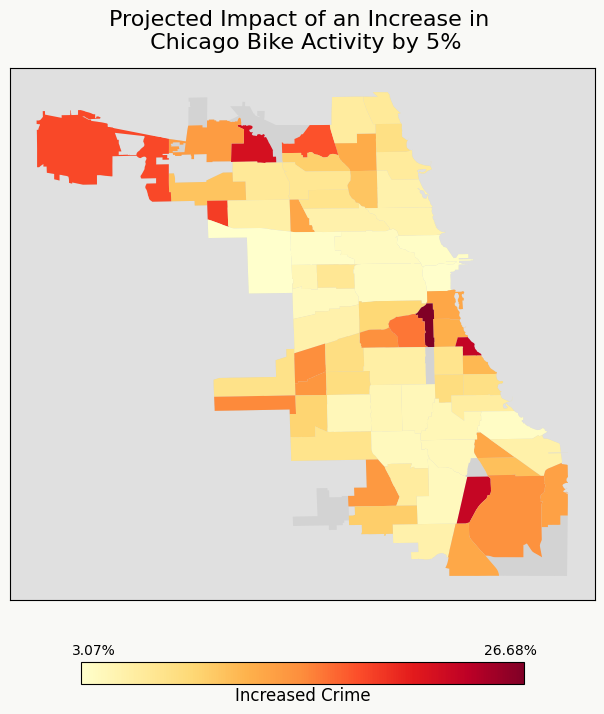

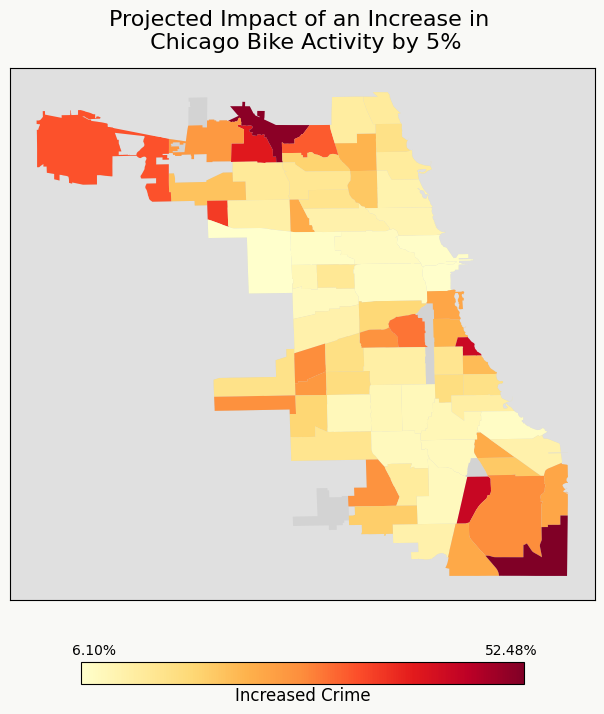

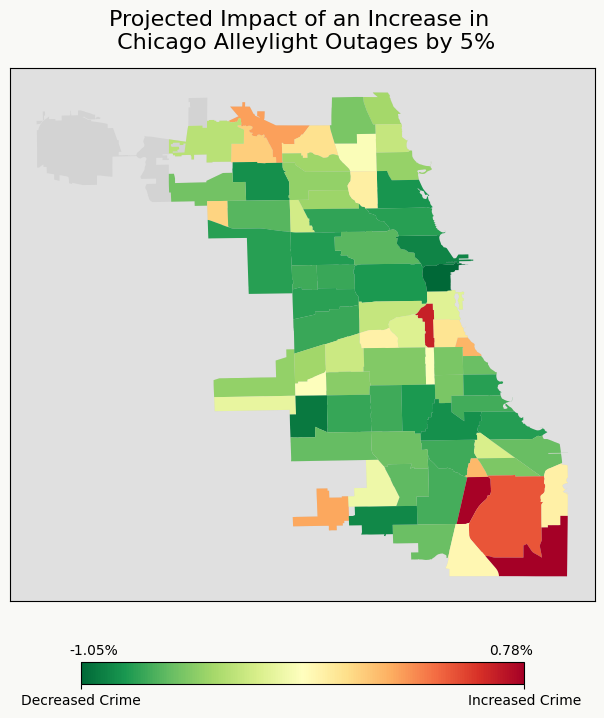

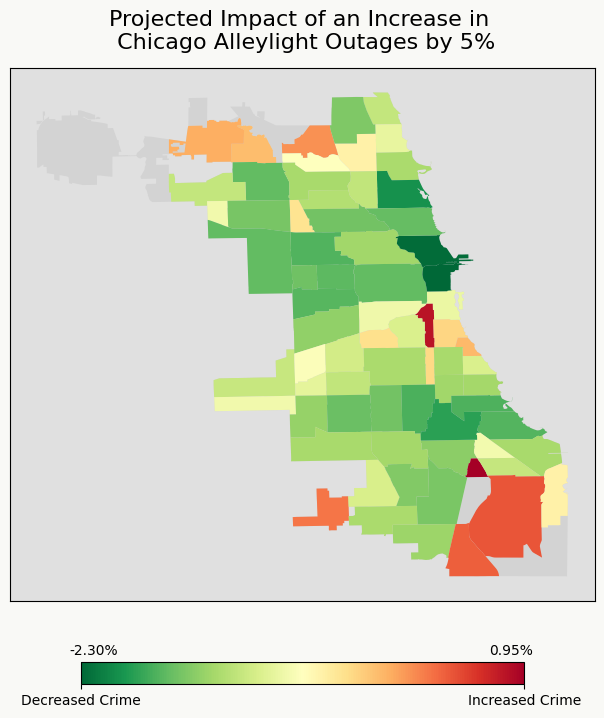

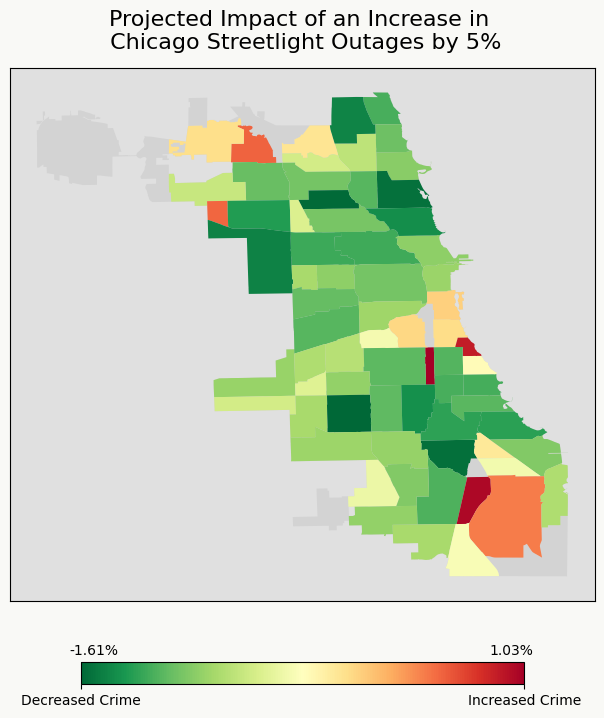

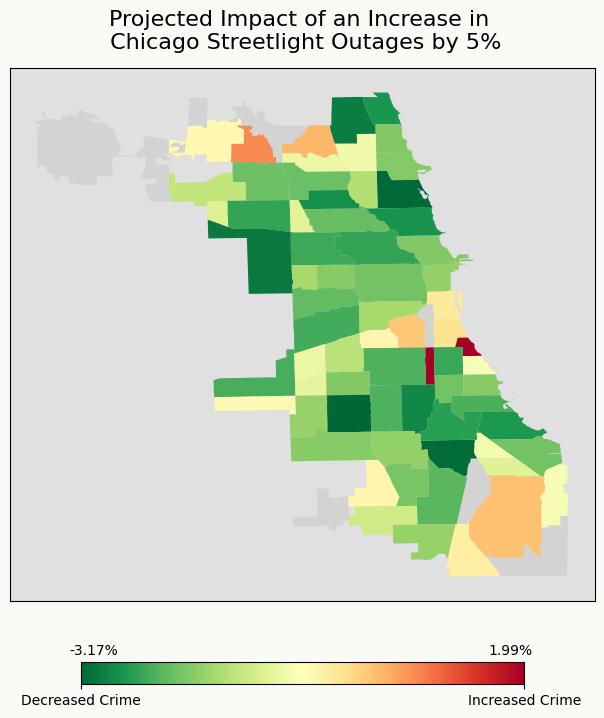

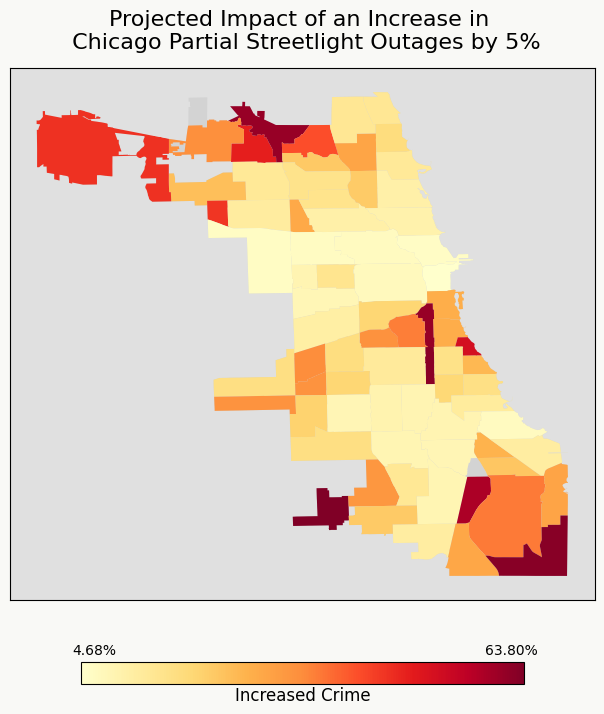

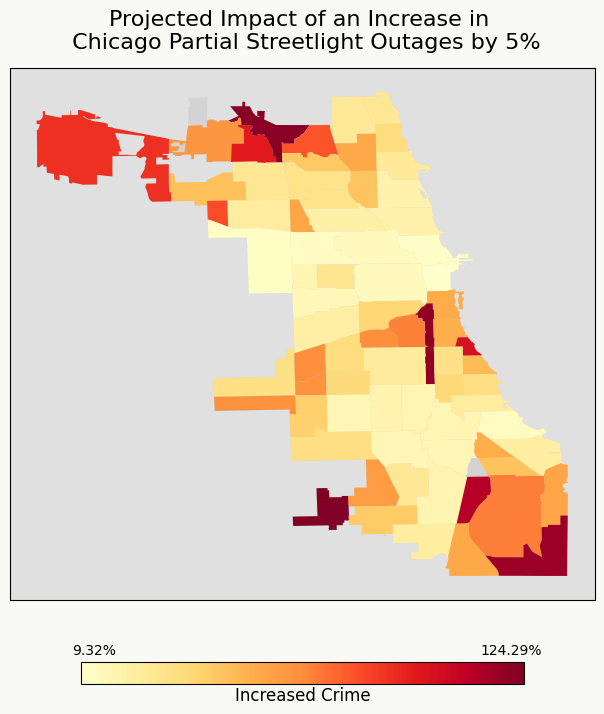

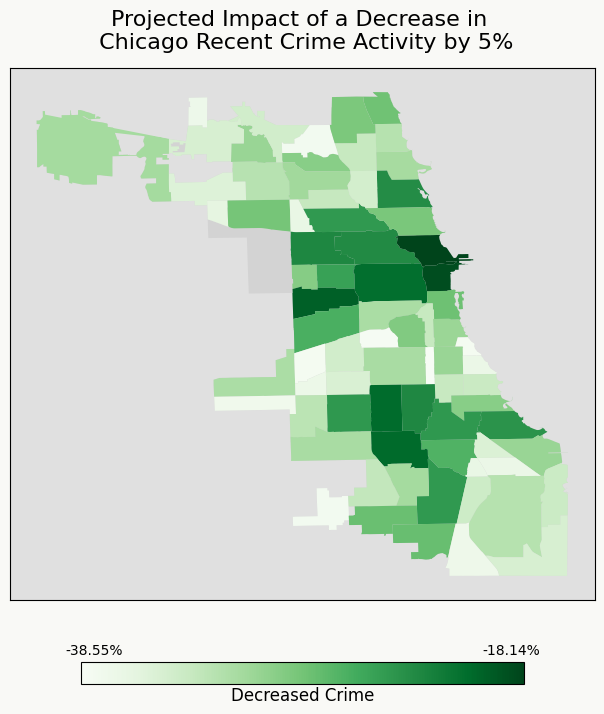

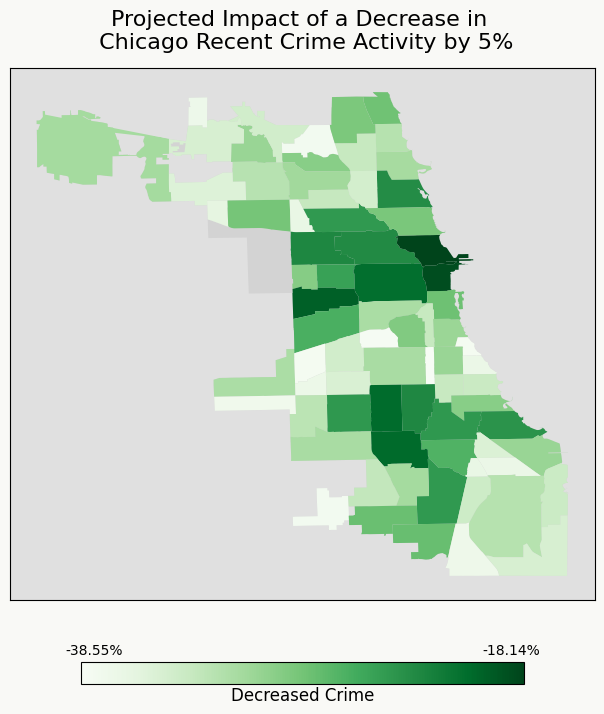

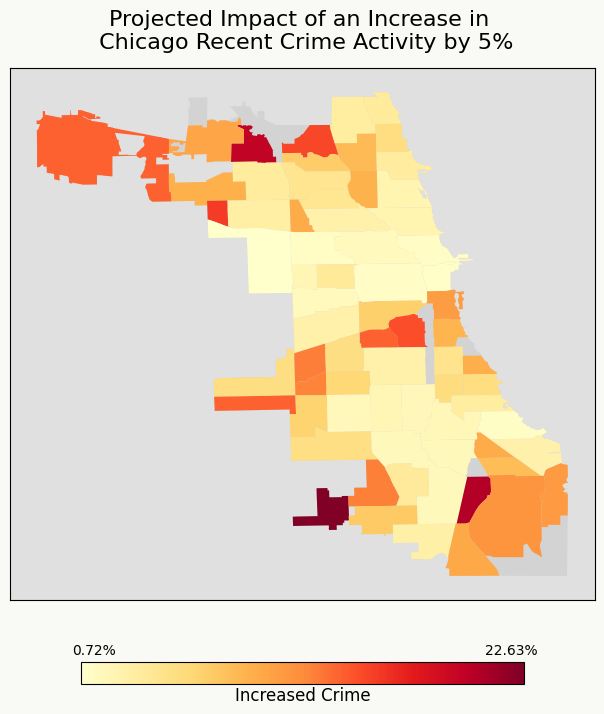

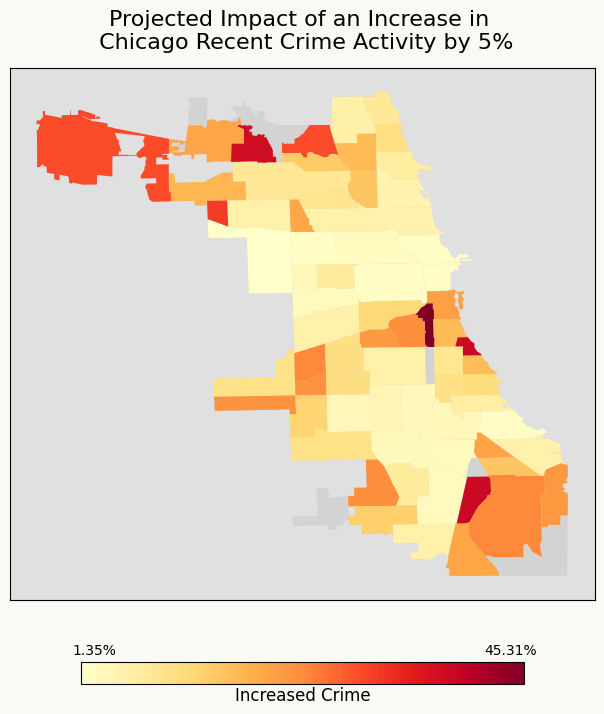

In [502]:
plot_heatmaps(geo_areas, area_residuals_df, 'area', savefig='../results/analysis/area')

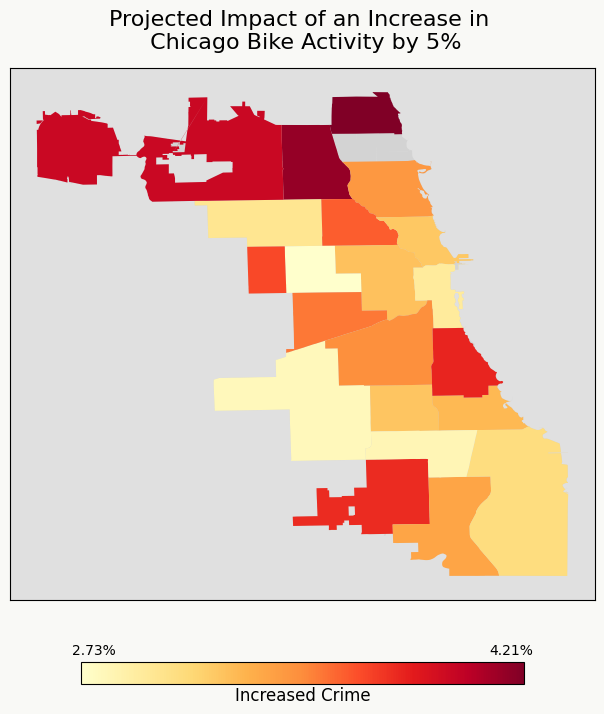

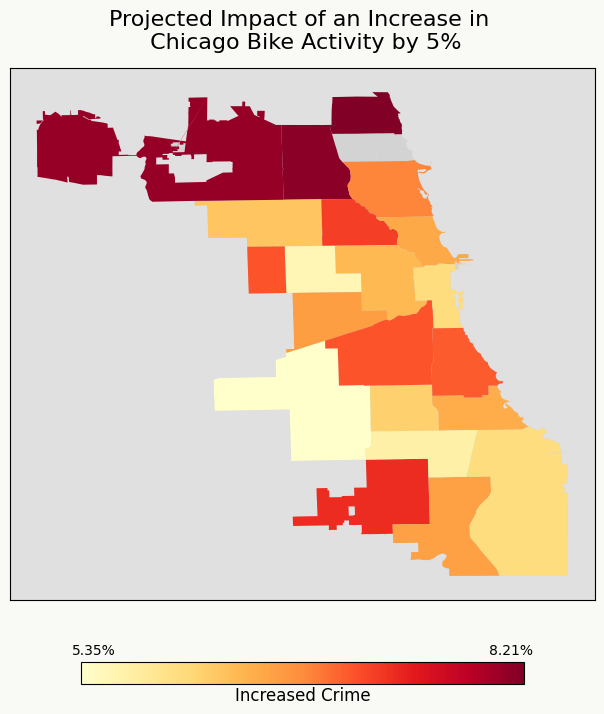

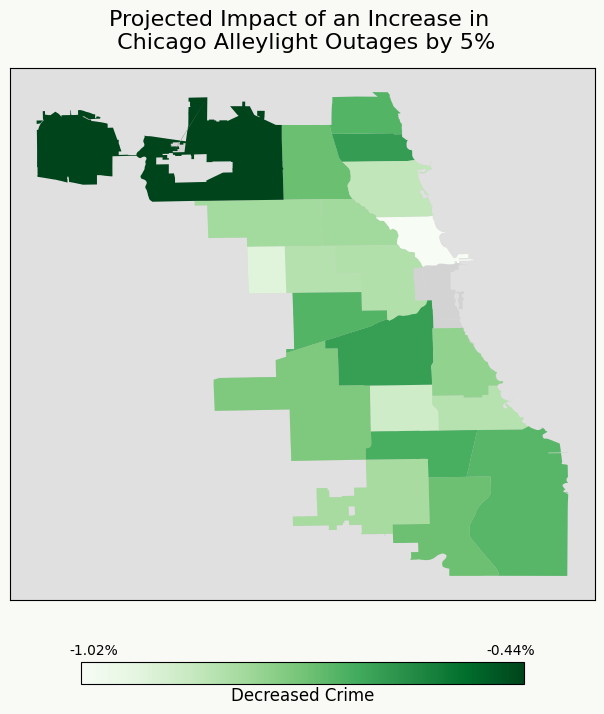

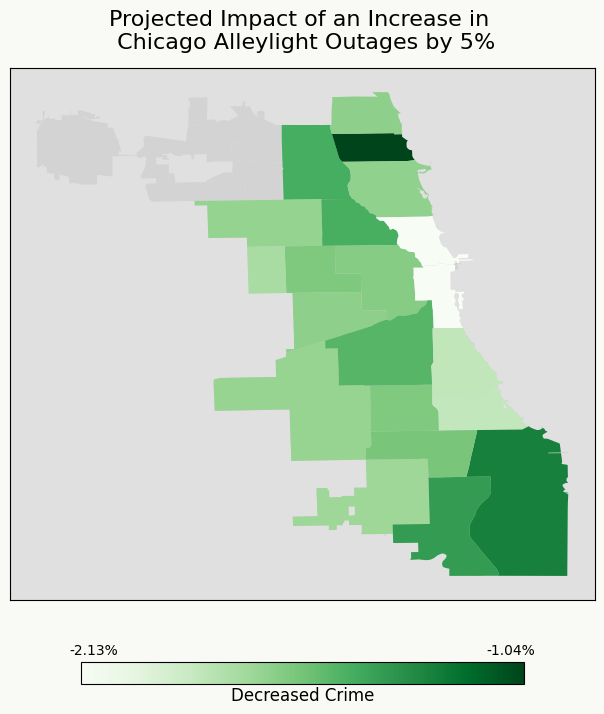

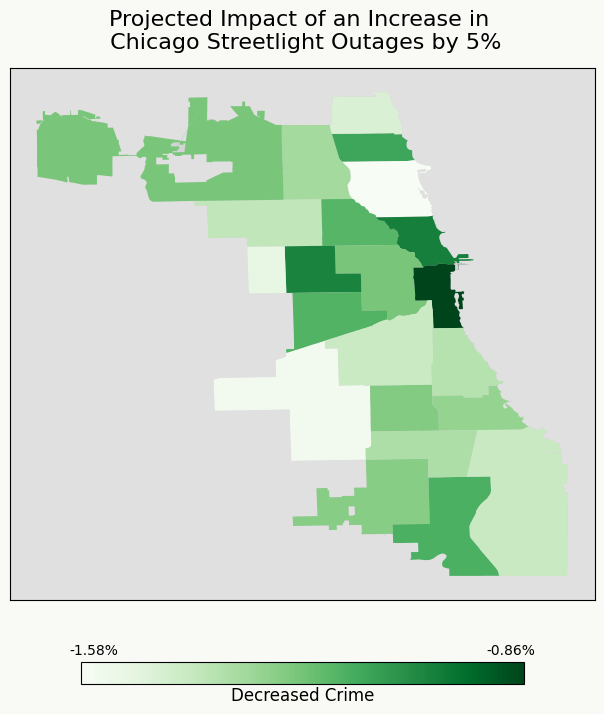

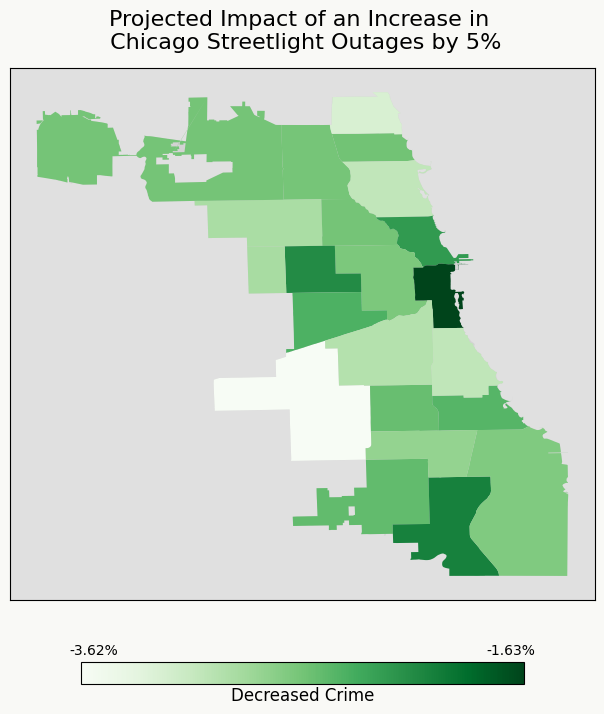

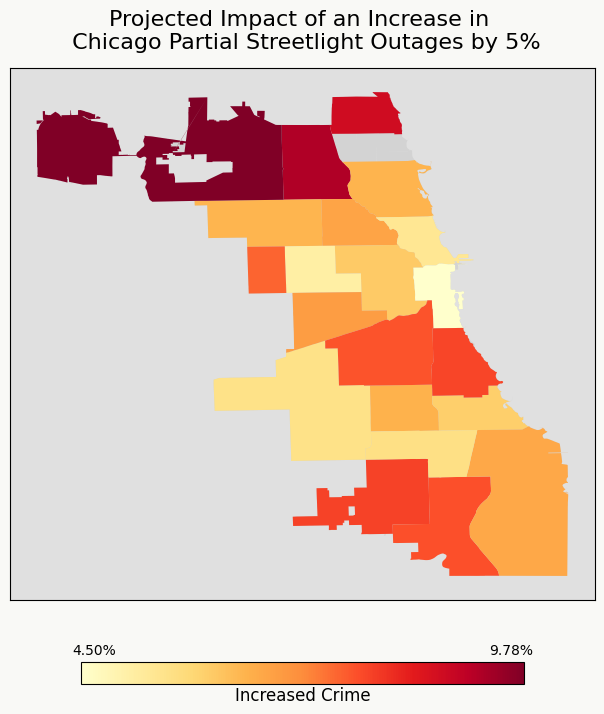

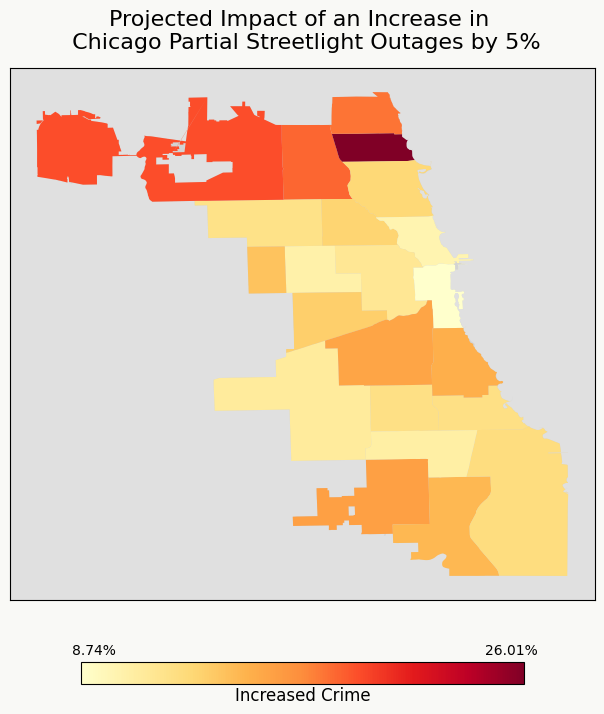

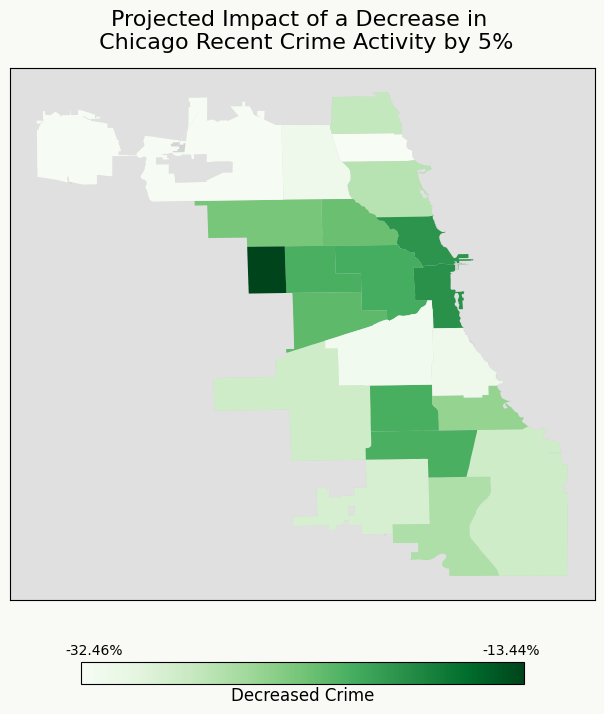

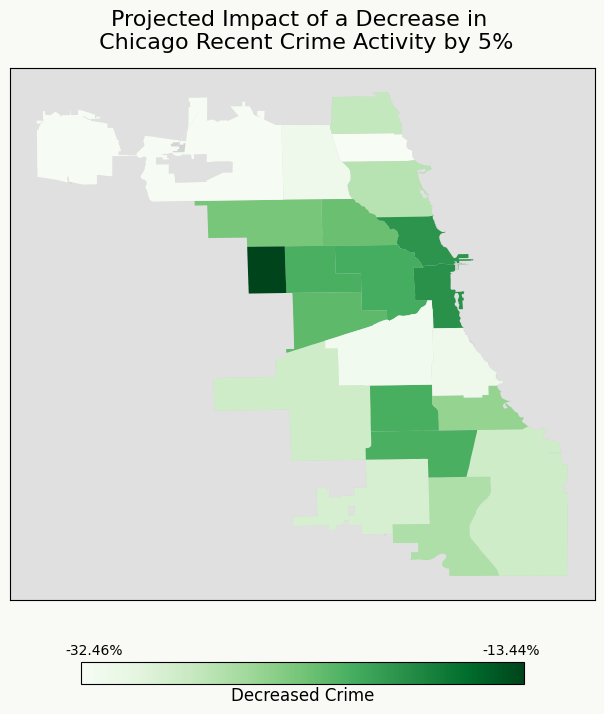

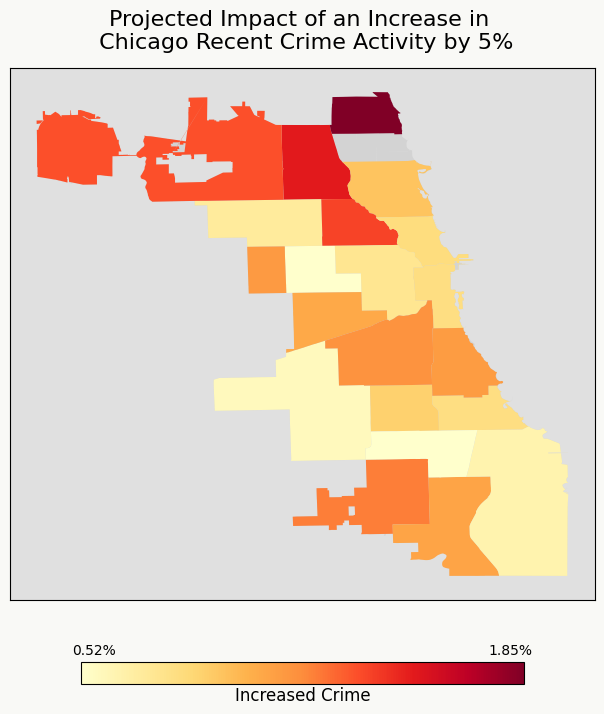

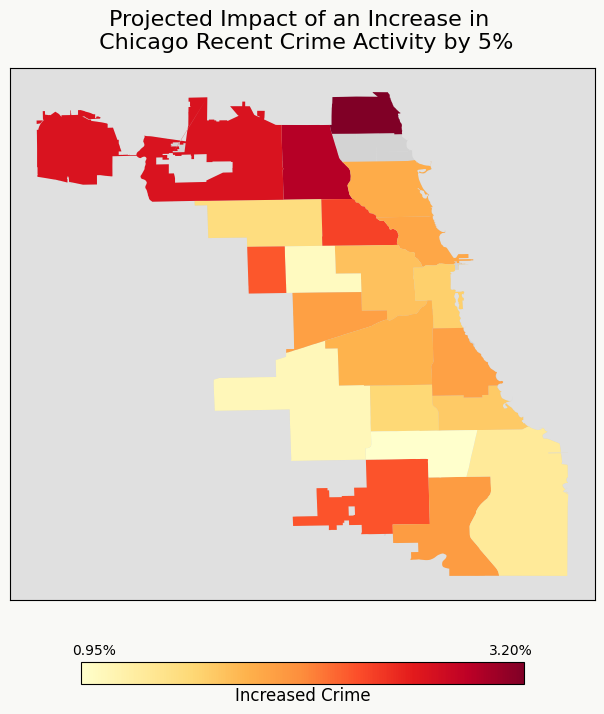

In [503]:
plot_heatmaps(geo_districts, district_residuals_df, 'district', savefig='../results/analysis/district')

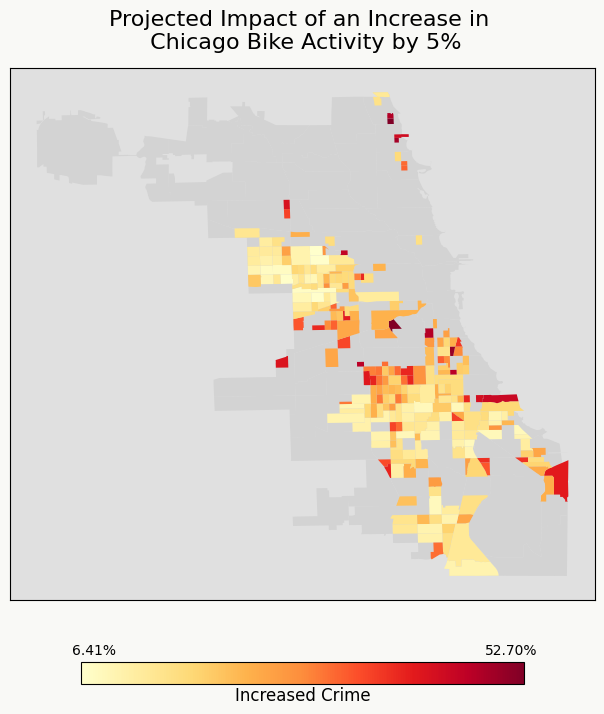

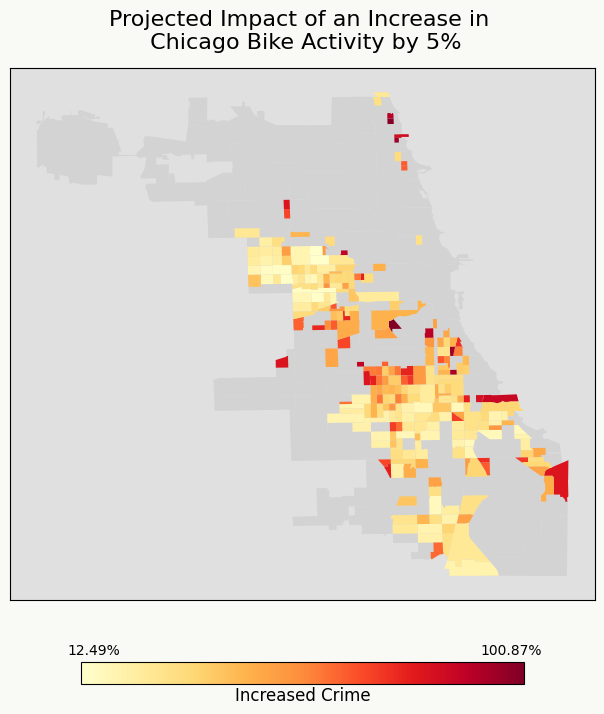

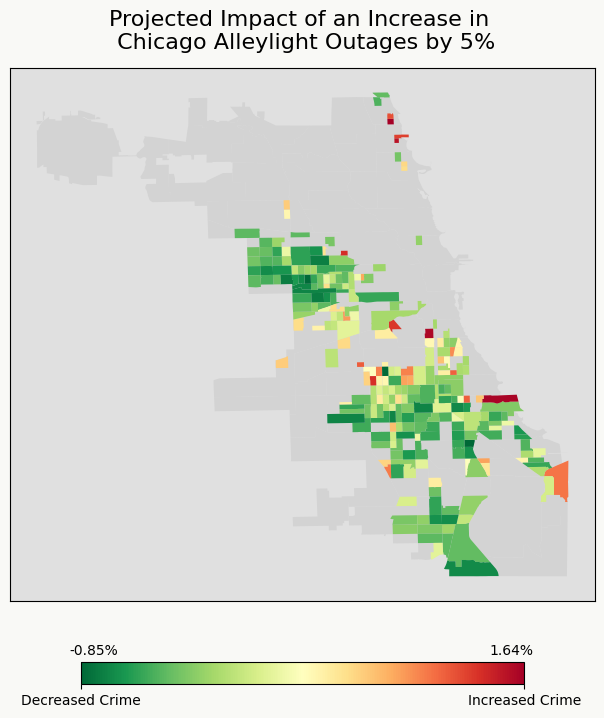

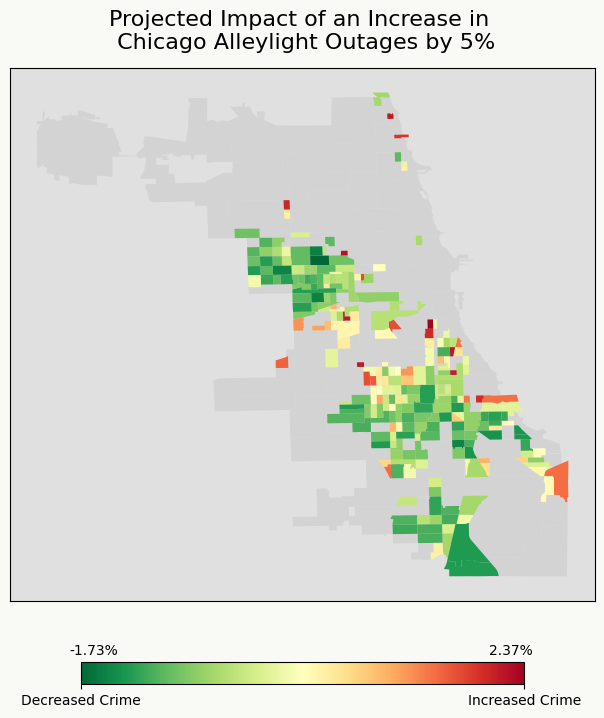

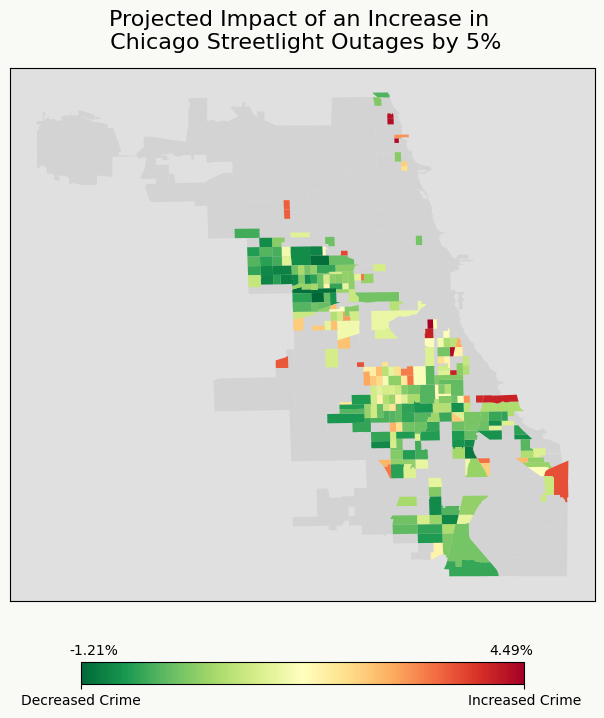

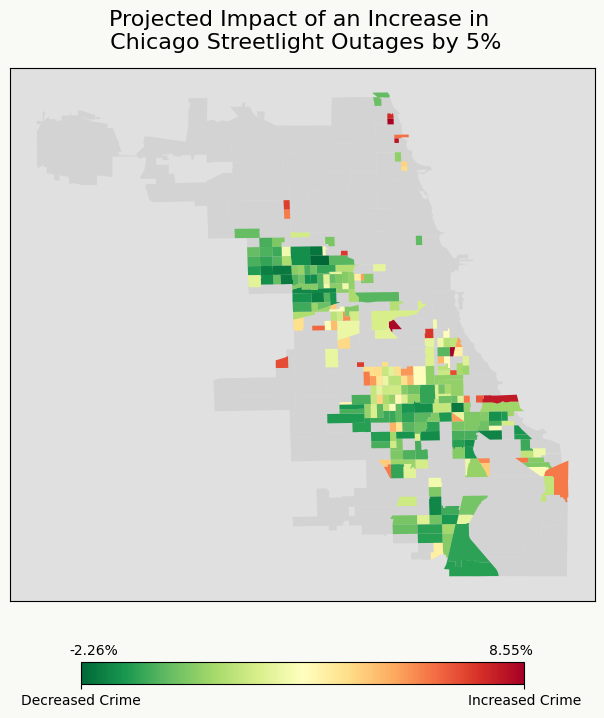

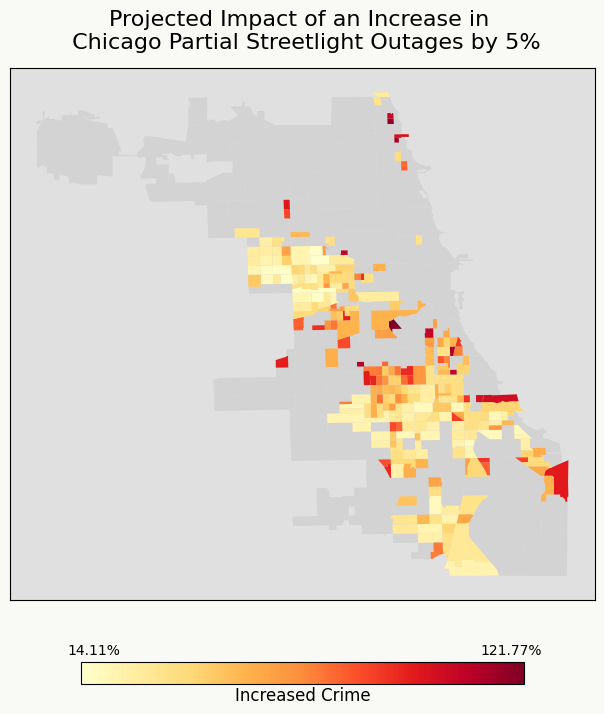

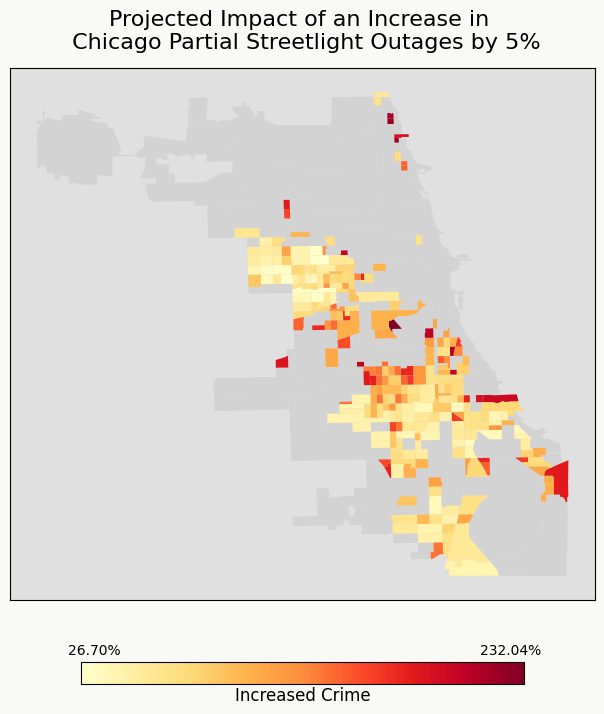

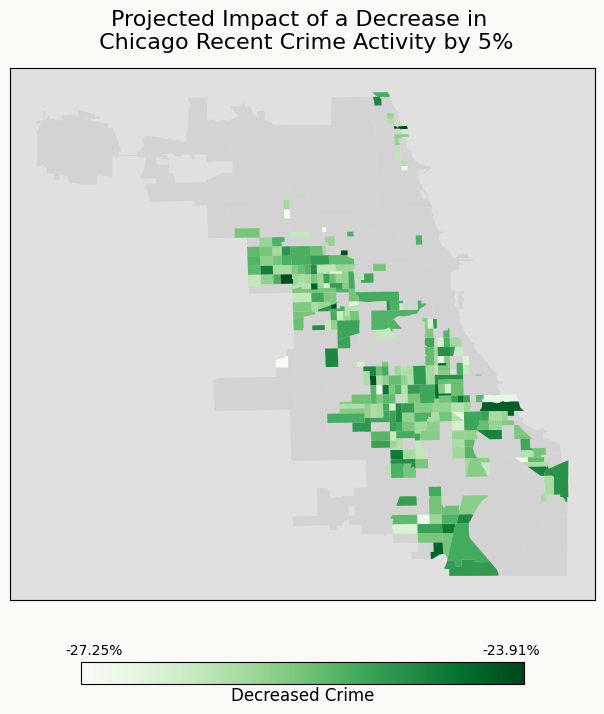

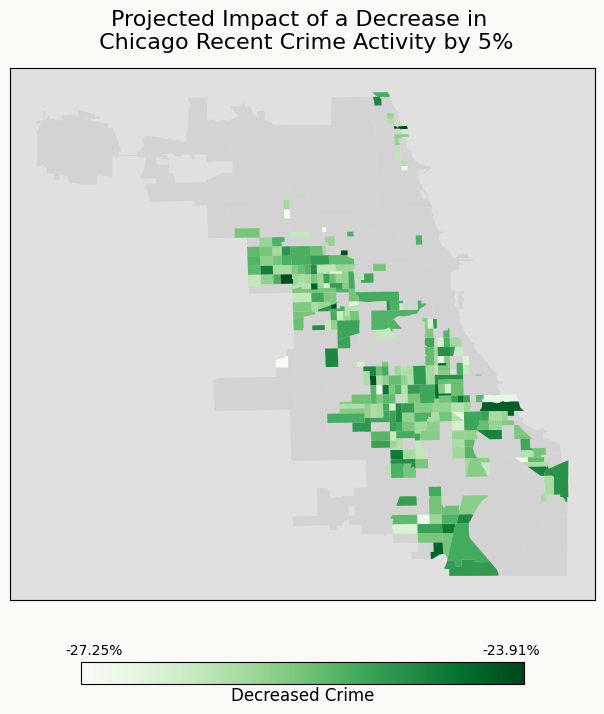

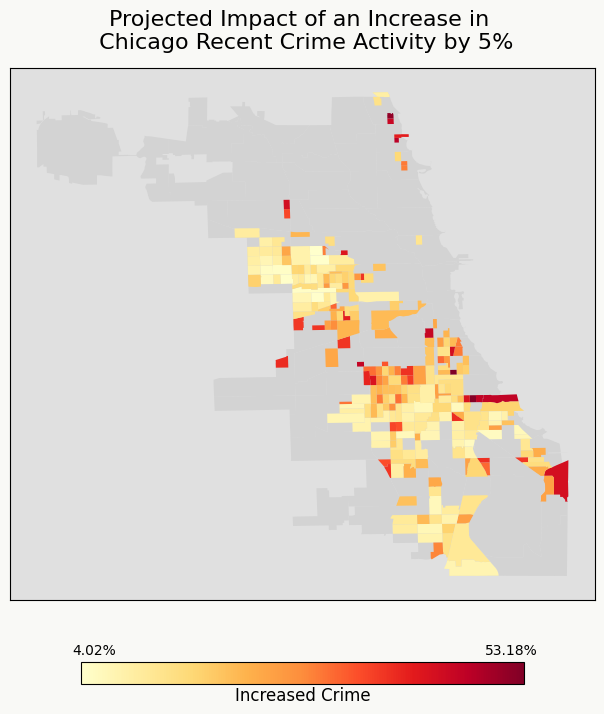

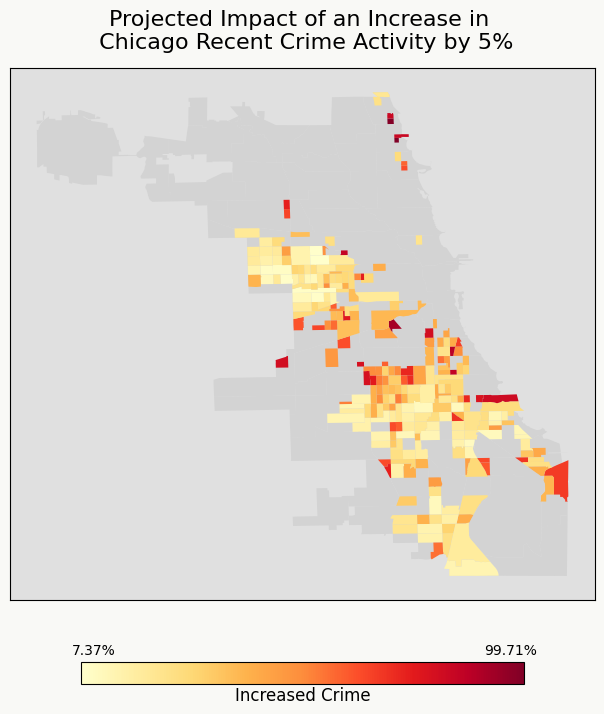

In [504]:
plot_heatmaps(geo_dis_areas, dis_area_residuals, 'area', savefig='../results/analysis/dis_area')

In [331]:
def make_geo_dfs(geo_df, df_dict, join_key):
    new_dict = {}
    for key, df in df_dict.items():
        new_df = geo_df.merge(df, left_on=join_key, right_on='geo')[['geo', 'geom', 'avg_perc_diff']]
        new_dict[key] = new_df
    return new_dict

In [338]:
geo_districts_dfs = make_geo_dfs(geo_districts, district_residuals_df, 'district')
geo_areas_dfs = make_geo_dfs(geo_areas, area_residuals_df, 'area')
geo_dis_areas_dfs = make_geo_dfs(geo_dis_areas, dis_area_residuals, 'area')

In [420]:
def single_plot_for_factor(factor, title, savefig=None, remove_outliers=True):
    fig, ax = plt.subplots(figsize=(8, 8), facecolor="#f9f9f6")
    ax.set_facecolor("#e0e0e0")

    chicago.plot(color='lightgrey', alpha=1, ax=ax)
    
    geo_dfs = [geo_districts_dfs, geo_areas_dfs, geo_dis_areas_dfs]
    cleaned_dfs = []
    for geo_df in geo_dfs:
        df = geo_df[factor].copy()

        if remove_outliers:
            Q1 = df['avg_perc_diff'].quantile(0.25)
            Q3 = df['avg_perc_diff'].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df['avg_perc_diff'] >= lower_bound) & 
                                    (df['avg_perc_diff'] <= upper_bound)]

        cleaned_dfs.append(df)

        vmin = df['avg_perc_diff'].min()
        vmax = df['avg_perc_diff'].max()

        if vmax < 1 and vmin > -1:
            plt.close(fig)
            return None

        if vmax <= -0.1:
            cmap = 'Greens'
        elif vmin >= 0.1:
            cmap = 'YlOrRd'
        else:
            cmap = 'RdYlGn_r'

        alphas = (df['avg_perc_diff'].abs() / max(abs(vmin), abs(vmax))) ** 2
        df.plot(column=df['avg_perc_diff'], cmap=cmap, ax=ax, alpha=alphas, edgecolor='none')

        plt.title(title, fontsize=16, pad=14)
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    total_df = pd.concat(cleaned_dfs)

    total_vmin = total_df['avg_perc_diff'].min()
    total_vmax = total_df['avg_perc_diff'].max()

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=total_vmin, vmax=total_vmax))
    sm.set_array([])

    cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.036, pad=0.1)

    if total_vmin >= -0.01 and total_vmin <= 0.01:
        cbar.set_ticks([0, total_vmax])
        cbar.set_ticklabels(['No Change', 'Increased Crime'])
    elif total_vmax >= -0.01 and total_vmax <= 0.01:
        cbar.set_ticks([total_vmin, 0])
        cbar.set_ticklabels(['Decreased Crime', 'No Change'])
    elif total_vmin >= 0.1:
        cbar.set_ticks([])
        cbar.ax.text(0.5, -0.5, 'Increased Crime', ha='center', va='center', fontsize=12, transform=cbar.ax.transAxes)
    elif total_vmax <= -0.1:
        cbar.set_ticks([])
        cbar.ax.text(0.5, -0.5, 'Decreased Crime', ha='center', va='center', fontsize=12, transform=cbar.ax.transAxes)
    else:
        cbar.set_ticks([total_vmin, total_vmax])
        cbar.set_ticklabels(['Decreased Crime', 'Increased Crime'])

    cbar.ax.text(0.03, 1.5, f'{round(total_vmin, 2)}%', ha='center', va='center', fontsize=10, color='black', transform=cbar.ax.transAxes)
    cbar.ax.text(0.97, 1.5, f'{round(total_vmax, 2)}%', ha='center', va='center', fontsize=10, color='black', transform=cbar.ax.transAxes)

    if savefig is not None:
        plt.savefig(savefig)

    plt.show()

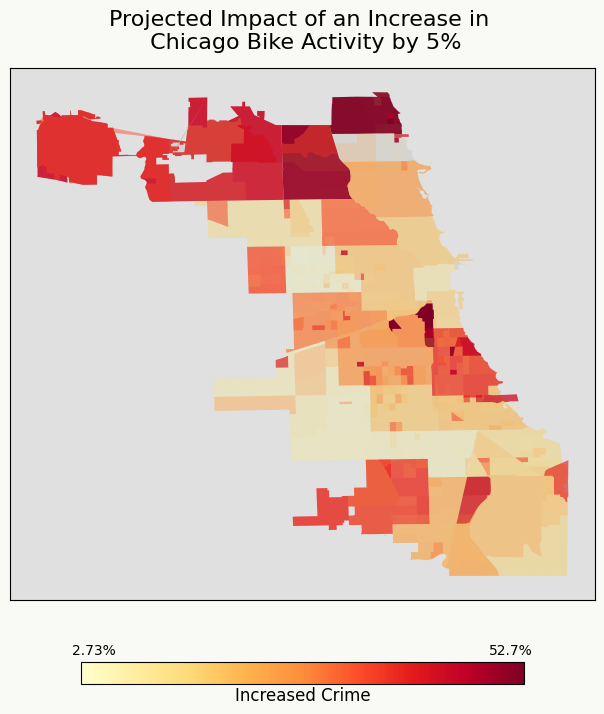

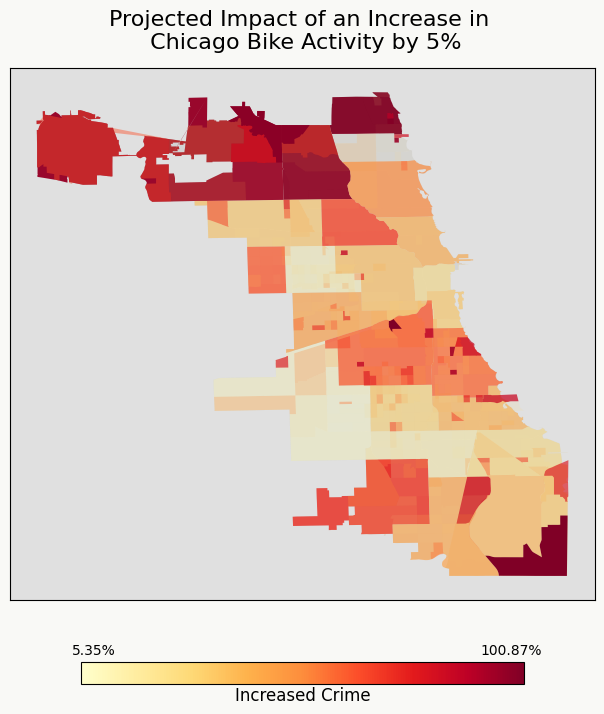

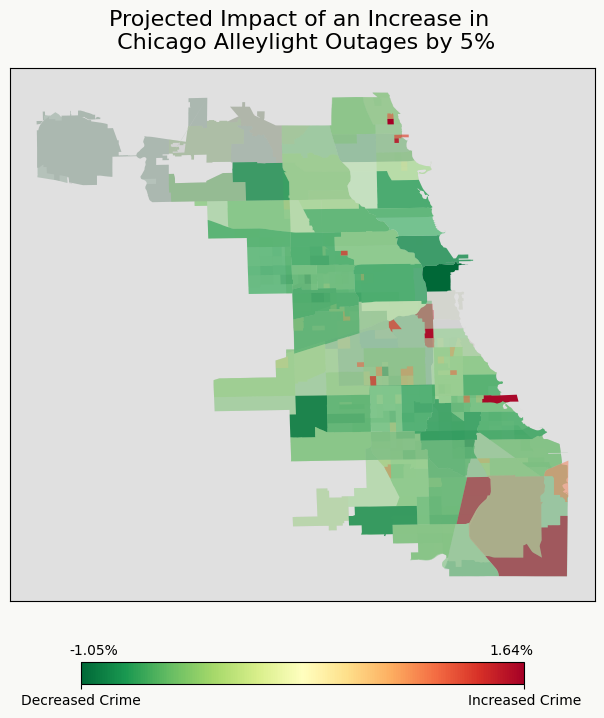

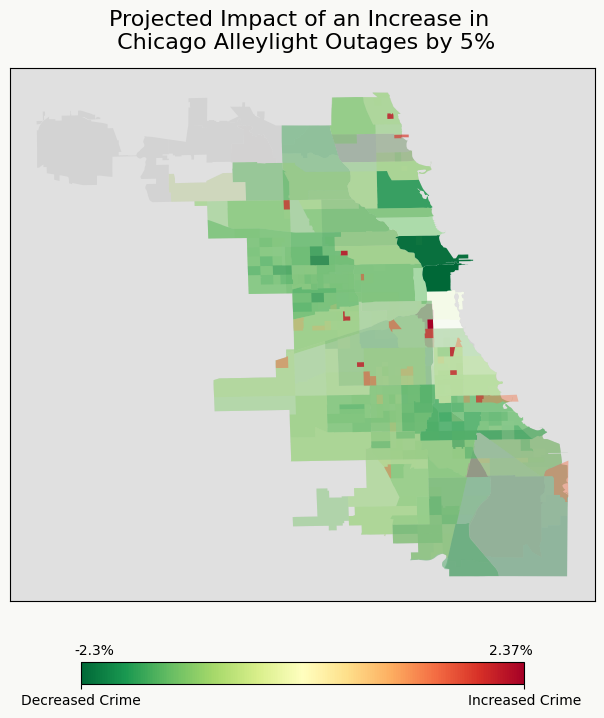

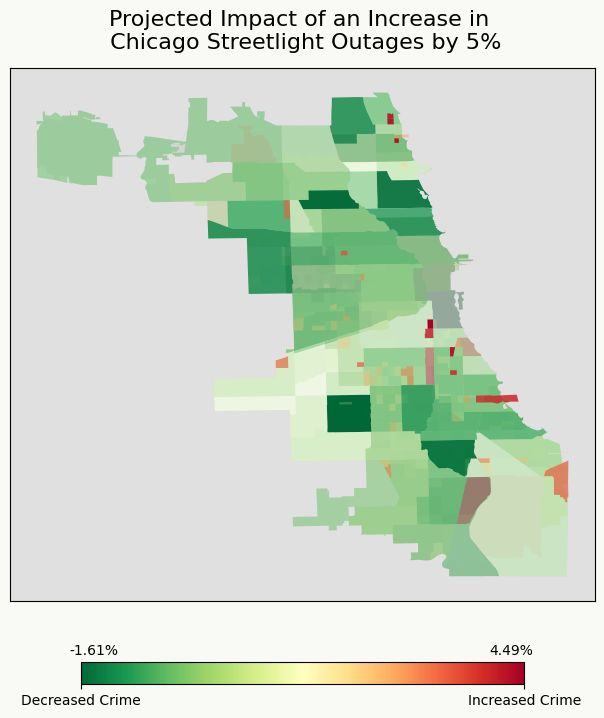

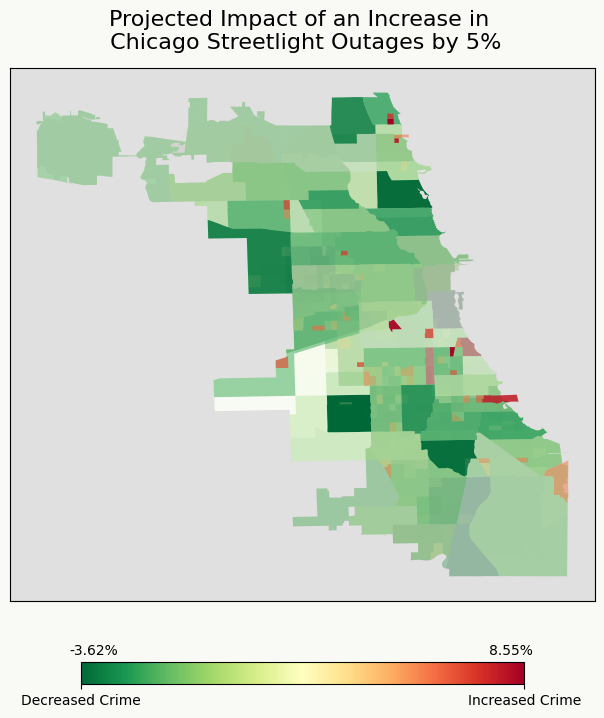

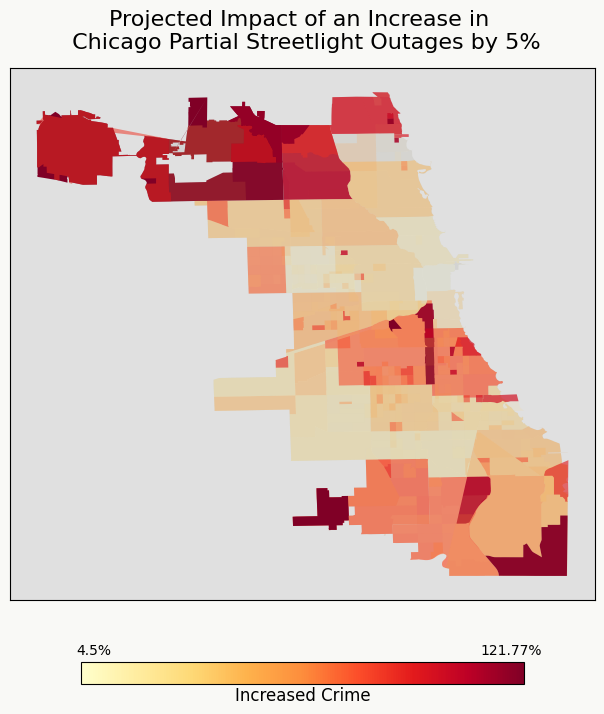

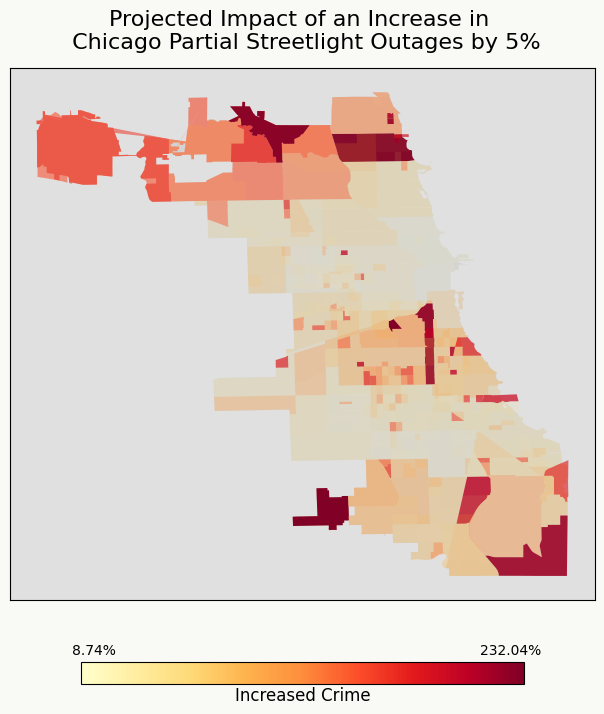

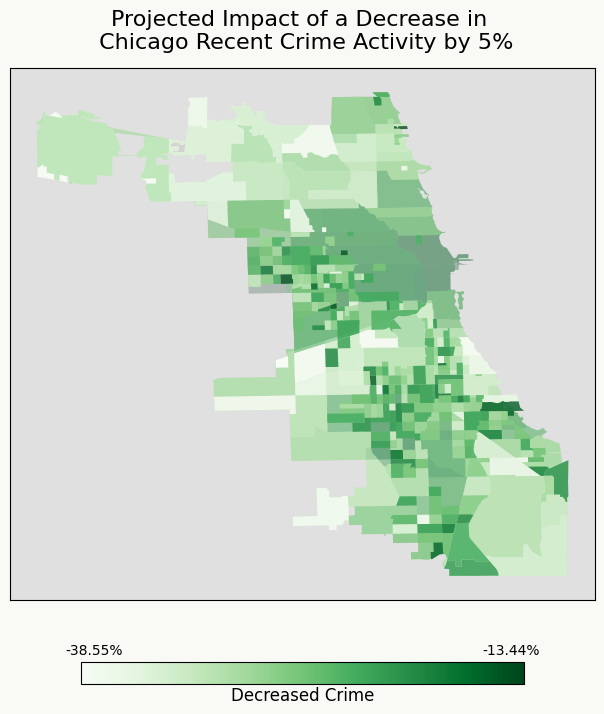

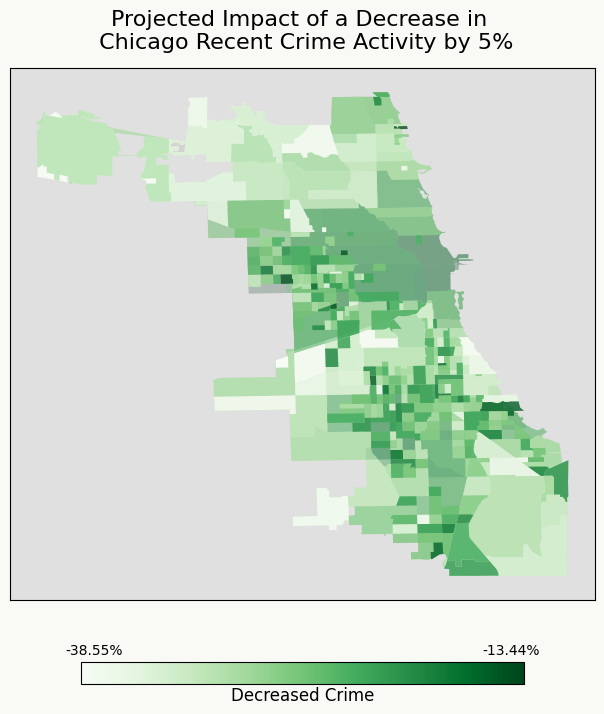

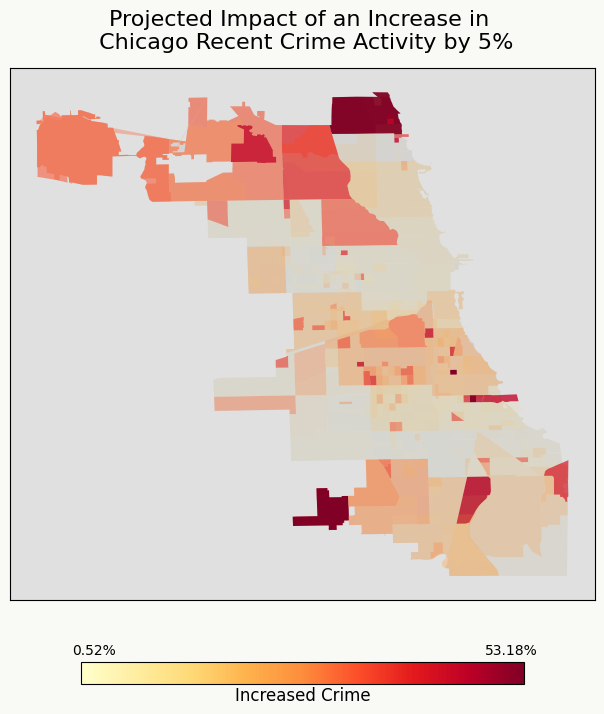

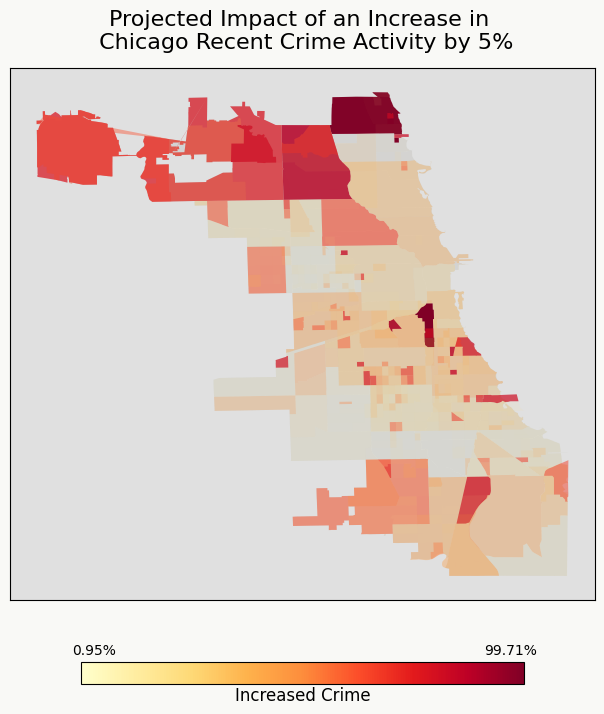

In [436]:
for key in district_predictions.keys():
    single_plot_for_factor(key, f'Projected Impact of {'a Decrease' if '-' in key else 'an Increase'} in \n Chicago {" ".join([k.capitalize() for k in key.split('_')[:-1]])} by {'10' if key.split('_')[-1] == 0.01 else '5'}%', savefig=f'../results/analysis/{key}_overlay.png')

In [ ]:
single_plot_for_factor('bus_stations_0.1', f'Projected Impact of {'a Decrease' if '-' in key else 'an Increase'} in \n Chicago {" ".join([k.capitalize() for k in key.split('_')[:-1]])} by {'10' if key.split('_')[-1] == 0.01 else '5'}%')